In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
# Based on tf xfer learning tutorial at https://www.tensorflow.org/tutorials/images/transfer_learning
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# These are all the package we'll use
from fastai.imports import *
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import time
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

In [3]:
#check to make sure you have access to a GPU
# torch.cuda.is_available()
# torch.backends.cudnn.enabled
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [10]:
## change below path to /tf/username/model_img/ALL
PATH = '/tf/visibility/model_img/0721_DS1alt/' #GFAL
data_dir = pathlib.Path(PATH)
#resize image 
# sz=224
# List containing the entries in the directory given by PATH
os.listdir(PATH)
image_count = len(list(data_dir.glob('*/*.jpg')))

#set batch size and original image dimensions
batch_size = 16 #TODO figure out what the OOM issue is
img_height = 720
img_width = 1280

#total image count
print(image_count)

32854


(720, 1280, 3)


array([[[157, 162, 166],
        [157, 162, 166],
        [157, 162, 166],
        [157, 162, 166]],

       [[157, 162, 166],
        [157, 162, 166],
        [157, 162, 166],
        [157, 162, 166]],

       [[157, 162, 166],
        [157, 162, 166],
        [157, 162, 166],
        [157, 162, 166]],

       [[157, 162, 166],
        [157, 162, 166],
        [157, 162, 166],
        [157, 162, 166]]], dtype=uint8)

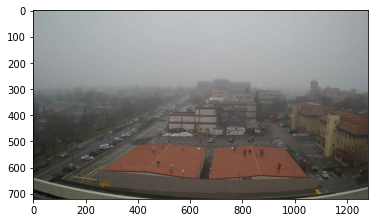

In [11]:
#do a quick check and make sure you have image data
files = os.listdir(f'{PATH}/0-1')[:10]
img = plt.imread(f'{PATH}/0-1/{files[9]}')
plt.imshow(img);
print(img.shape)
# First 4 rows and columns of the image
img[:4,:4]

In [12]:
def read_dirs(path, folder):
    labels, filenames, all_labels = [], [], []
    full_path = os.path.join(path, folder)
    for label in sorted(os.listdir(full_path)):
        if label != '.ipynb_checkpoints': #not in ('.ipynb_checkpoints'):
            all_labels.append(label)
            for fname in os.listdir(os.path.join(full_path, label)):
                filenames.append(os.path.join(folder, label, fname))
                labels.append(label)
    return filenames, labels, all_labels

In [ ]:
#run rm -rf .ipynb_checkpoints to get correct class names
%cd /tf/visibility/model_img/0721_DS1alt/
%rm -rf .ipynb_checkpoints

In [13]:
def prep_fn(img):
    """
    Convert pixel values from [0, 255] to [-1, 1]
    """
    img = img.astype(np.float32) / 255.0
    img = (img - 0.5) * 2
    return img

In [14]:
#set up generators for training and validation data

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    zoom_range=0.1,
    preprocessing_function=prep_fn)
#train_datagen.fit(np.stack(list(train_ds)))
train_datagen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=prep_fn, validation_split=0.2)
val_datagen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=prep_fn, validation_split=0.2)

gen_kwargs = dict(seed=123, batch_size=batch_size, class_mode='categorical',
                  target_size=(img_height, img_width), classes = {'0-1': 0, '2': 1, '3': 2, '4': 3})
train_gen = train_datagen.flow_from_directory(
    data_dir,
    subset="training",
    **gen_kwargs
    )
val_gen = val_datagen.flow_from_directory(
    data_dir,
    subset="validation",
    **gen_kwargs)

Found 26295 images belonging to 4 classes.
Found 6573 images belonging to 4 classes.


In [16]:
#comment out if doing cropping
#del(train_ds.class_names[0])
#del(val_ds.class_names[0])
class_names = [key for key in train_gen.class_indices]
print(class_names)

['0-1', '2', '3', '4']


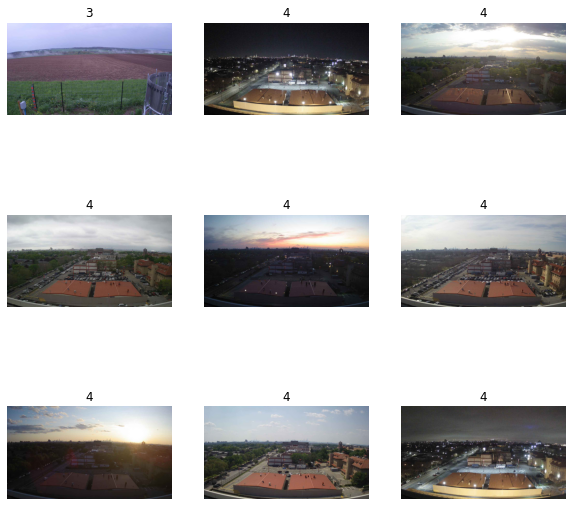

In [17]:
#display a few images for a sanity check (all labels should be correct, and no imgs should be corrupted)
plt.figure(figsize=(10, 10))
images, labels = next(iter(train_gen))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[i] + 1) / 2)
    plt.title(class_names[np.where(labels[i] == 1)[0][0]])
    plt.axis("off")

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = images.shape[1:]
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights=None) #'imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_gen)) #batch size of 128 is too large for memory. Is there any way to get image_batch from the datagens? W/o using datagen.fit()?
feature_batch = base_model(image_batch)
print(feature_batch.shape)

**Lock pretrained model weights so they aren't thrown off by the untrained classification layers:**

In [6]:
base_model.trainable = False
base_model.summary()

NameError: name 'base_model' is not defined

In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=True) #TODO does fit() automatically set training=True, or should I do that here?
x = tf.keras.layers.Conv2D(512, 5, padding='same', activation='relu')(x)
x = tf.keras.layers.Conv2D(256, 5, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(64, 7, padding='same', activation='relu')(x)
x = tf.keras.layers.Conv2D(32, 7, padding='same', activation='relu')(x) #TODO more filters
x = tf.keras.layers.MaxPooling2D()(x)

#transition to dense layers
x = tf.keras.layers.Flatten()(x) #global_average_layer(x)
#TODO try flatten instead of global avg?
x = tf.keras.layers.Dropout(0.4)(x)
#x = tf.keras.layers.Dense(x.shape[1], activation = 'elu')(x) #TODO first dense layer should be abt 100 units
for i in range(1, 3):
    x = tf.keras.layers.Dense(x.shape[1] / 6, activation = 'elu')(x) #TODO different activ func (ELU?)
outputs = tf.keras.layers.Dense(len(class_names), activation = 'softmax')(x) #should I be using one-hot encoding?
model = tf.keras.Model(inputs, outputs)

In [37]:
base_learning_rate = 3e-4
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), #logits are raw model output, not probabilities
              metrics=['accuracy'])

In [ ]:
model.summary()

In [40]:
class_wgt = {0: 28, 1: 22, 2: 10, 3: 1}
train_kwargs = dict(validation_data=val_gen, steps_per_epoch = 5, #train_gen.samples/train_gen.batch_size,
                    validation_steps=5, #val_gen.samples/val_gen.batch_size,
                    #callbacks = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = .1, patience = 3, verbose = 1, min_lr=1e-6),
                    class_weight=class_wgt)
epochs = 5
history = model.fit(
  train_gen,
  epochs=epochs,
  **train_kwargs
)

Epoch 1/5
5/5 [==============================] - 15s 2s/step - loss: 9.7471 - accuracy: 0.4948 - val_loss: 1.6336 - val_accuracy: 0.1375
Epoch 2/5
5/5 [==============================] - 8s 2s/step - loss: 4.3554 - accuracy: 0.2967 - val_loss: 2.1999 - val_accuracy: 0.1000
Epoch 3/5
5/5 [==============================] - 8s 2s/step - loss: 11.8322 - accuracy: 0.2002 - val_loss: 1.0334 - val_accuracy: 0.6875
Epoch 4/5
5/5 [==============================] - 8s 2s/step - loss: 2.9874 - accuracy: 0.7741 - val_loss: 0.9622 - val_accuracy: 0.8375
Epoch 5/5
5/5 [==============================] - 8s 2s/step - loss: 4.2814 - accuracy: 0.5295 - val_loss: 1.4170 - val_accuracy: 0.0250


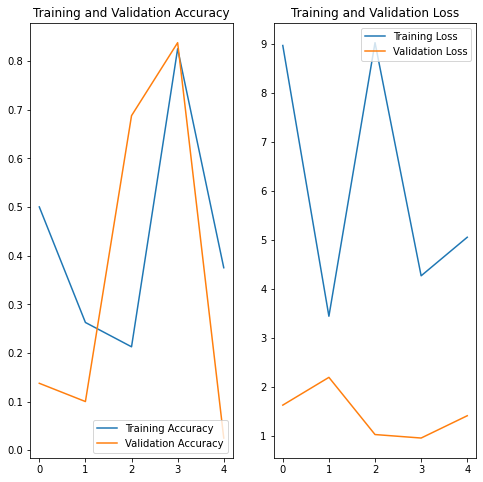

In [41]:
total_epochs = epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [38]:
#additional epochs
epochs = 10
addl_history = model.fit(
  train_gen,
  epochs=epochs,
  **train_kwargs
)

total_epochs += epochs
acc += addl_history.history['accuracy']
val_acc += addl_history.history['val_accuracy']

loss += addl_history.history['loss']
val_loss += addl_history.history['val_loss']

NameError: name 'train_kwargs' is not defined

In [39]:
epochs_range = range(total_epochs)

plt.rcdefaults()
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.ylim(0, 2.5)
plt.show()

NameError: name 'total_epochs' is not defined

[[0.3584444  0.21200931 0.18776837 0.2417779 ]]
This image most likely belongs to 0-1 with a 35.84 percent confidence.


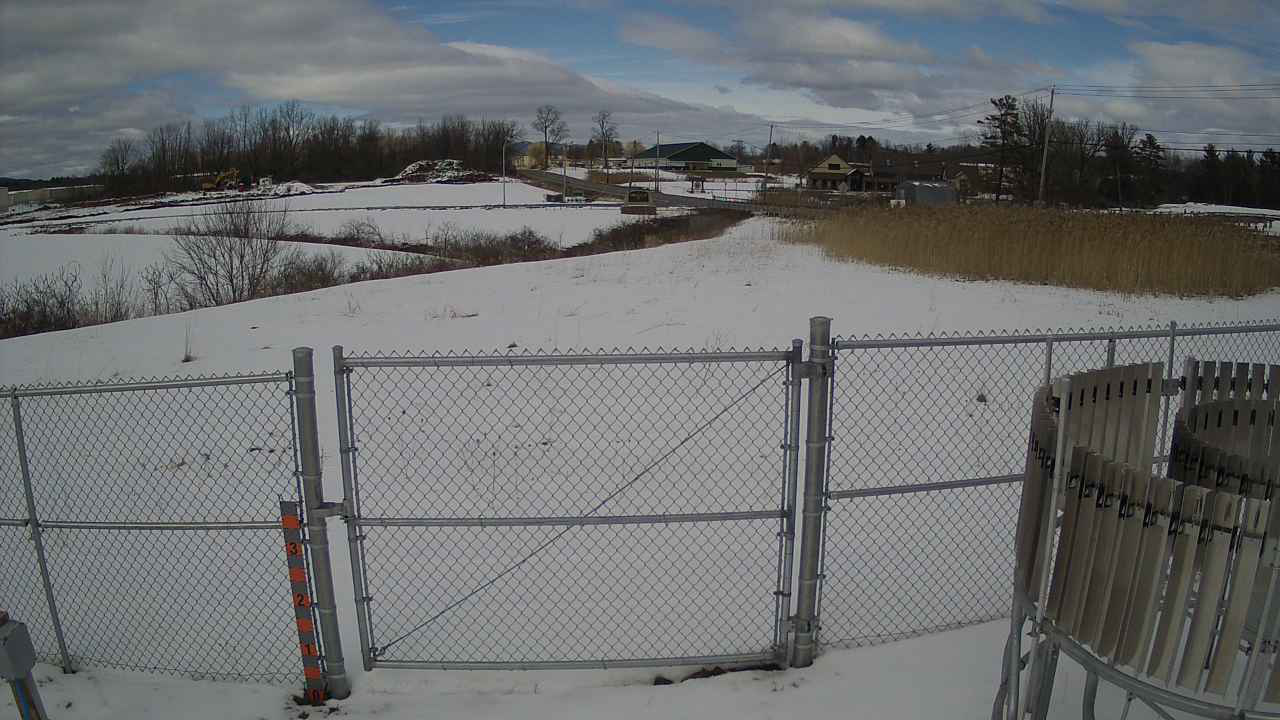

In [42]:
import glob

samples = ['/tf/NYSM/archive/nysm/cam_photos/2017/03/14/GFAL/20170314T150004_GFAL.jpg',
           '/tf/NYSM/archive/nysm/cam_photos/2019/05/05/BELD/20190505T135027_BELD.jpg',
           '/tf/NYSM/archive/nysm/cam_photos/2018/03/03/SCIP/20180303T125029_SCIP.jpg',
           '/tf/NYSM/archive/nysm/cam_photos/2019/05/15/GFAL/20190515T130527_GFAL.jpg',  #perfect vis with blue sky
           '/tf/NYSM/archive/nysm/cam_photos/2020/09/09/BATA/20200909T120026_BATA.jpg', #thick fog
           '/tf/NYSM/archive/nysm/cam_photos/2020/12/17/BATA/20201217T220027_BATA.jpg', #snow on the ground
           '/tf/NYSM/archive/nysm/cam_photos/2020/11/17/BATA/20201117T180026_BATA.jpg', #light fog
           '/tf/NYSM/archive/nysm/cam_photos/2020/09/24/BATA/20200924T180027_BATA.jpg', #perfect vis with hazy sky
           '/tf/NYSM/archive/nysm/cam_photos/2019/01/30/MANH/20190130T203528_MANH.jpg', #'/tf/NYSM/archive/nysm/cam_photos/2019/01/30/QUEE/20190130T204528_QUEE.jpg',
           '/tf/NYSM/archive/nysm/cam_photos/2019/01/30/MANH/20190130T192527_MANH.jpg', #'/tf/NYSM/archive/nysm/cam_photos/2019/01/30/QUEE/20190130T190527_QUEE.jpg',
           '/tf/NYSM/archive/nysm/cam_photos/2021/02/03/GROT/20210203T112533_GROT.jpg',
           '/tf/NYSM/archive/nysm/cam_photos/2018/07/16/PENN/20180716T083028_PENN.jpg']
new_img_path = '/tf/NYSM/archive/nysm/cam_photos/2018/03/11/GFAL/20180311T180026_GFAL.jpg' #'/tf/NYSM/archive/nysm/cam_photos/2021/02/05/BATA/20210205T050026_BATA.jpg'

'''samples = ['/tf/NYSM/archive/nysm/cam_photos/2021/02/02/GABR/20210202T190034_GABR.jpg',
           '/tf/NYSM/archive/nysm/cam_photos/2021/04/14/GABR/20210414T123531_GABR.jpg',
           '/tf/NYSM/archive/nysm/cam_photos/2021/03/09/GABR/20210309T132036_GABR.jpg',
           '/tf/NYSM/archive/nysm/cam_photos/2021/02/02/GABR/20210202T211033_GABR.jpg',
           '/tf/NYSM/archive/nysm/cam_photos/2018/03/02/GABR/20180302T150526_GABR.jpg']'''

'''samples = ['/tf/visibility/model_img/0709_overfit/excellent/20210314T130034_GABR.jpg',
           '/tf/visibility/model_img/0709_overfit/excellent/20210314T130034_GABR.jpg',
           '/tf/visibility/model_img/0709_overfit/fair/20210314T180034_GABR.jpg',
           '/tf/visibility/model_img/0709_overfit/fair/20210314T190033_GABR.jpg',
           '/tf/visibility/model_img/0709_overfit/fair/20210314T200033_GABR.jpg',
           '/tf/visibility/model_img/0709_overfit/fair/20210314T210034_GABR.jpg',
           '/tf/visibility/model_img/0709_overfit/reduced/20210314T110033_GABR.jpg',
           '/tf/visibility/model_img/0709_overfit/reduced/20210314T120035_GABR.jpg',
           '/tf/visibility/model_img/0709_overfit/reduced/20210314T140033_GABR.jpg',
           '/tf/visibility/model_img/0709_overfit/reduced/20210314T170034_GABR.jpg',
           '/tf/visibility/model_img/0709_overfit/poor/20210314T150037_GABR.jpg',
           '/tf/visibility/model_img/0709_overfit/poor/20210314T160034_GABR.jpg'] #overfit test'''

#samples = glob.glob('/tf/visibility/model_img/0712_GABR_man/excellent/*.jpg')[:12]
#samples = glob.glob('/tf/visibility/model_img/0714_GABR_man/fair/*.jpg')[:12]
#samples = glob.glob('/tf/visibility/model_img/0714_GABR_man/reduced/*.jpg')[:12]
#samples = glob.glob('/tf/visibility/model_img/0712_GABR_man/poor/*.jpg')[:12]

img = keras.preprocessing.image.load_img(
    new_img_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = prep_fn(img_array)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = predictions[0] #tf.nn.softmax(predictions[0]) #TODO get rid of softmax since activation already has it
print(predictions)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
PIL.Image.open(new_img_path)

In [43]:
def predict1(model, class_names, path = None, norm_img = None, img_height = 720, img_width = 1280):
    """
    Returns the predicted class and percent confidence for an image.
    
    :Parameters:
        model (tf model)
        class_names (list of str)
        path (str): path to image
        norm_img (array representation of image)
        
    :rtype: tuple (str, float, 1d np array)
    """
    img_array = None
    
    if path:
        img = keras.preprocessing.image.load_img(
        path, target_size=(img_height, img_width)
        )
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = prep_fn(img_array)
        img_array = tf.expand_dims(img_array, 0) # Create a batch
    elif norm_img is not None:
        img_array = np.array([norm_img])
    else:
        raise TypeError('Need to pass either image path or image array as an argument.')

    predictions = model.predict(img_array)
    score = predictions[0]
    
    #print(predictions)
    return (class_names[np.argmax(score)], 100 * np.max(score), score)

    #TODO show all 4 probs

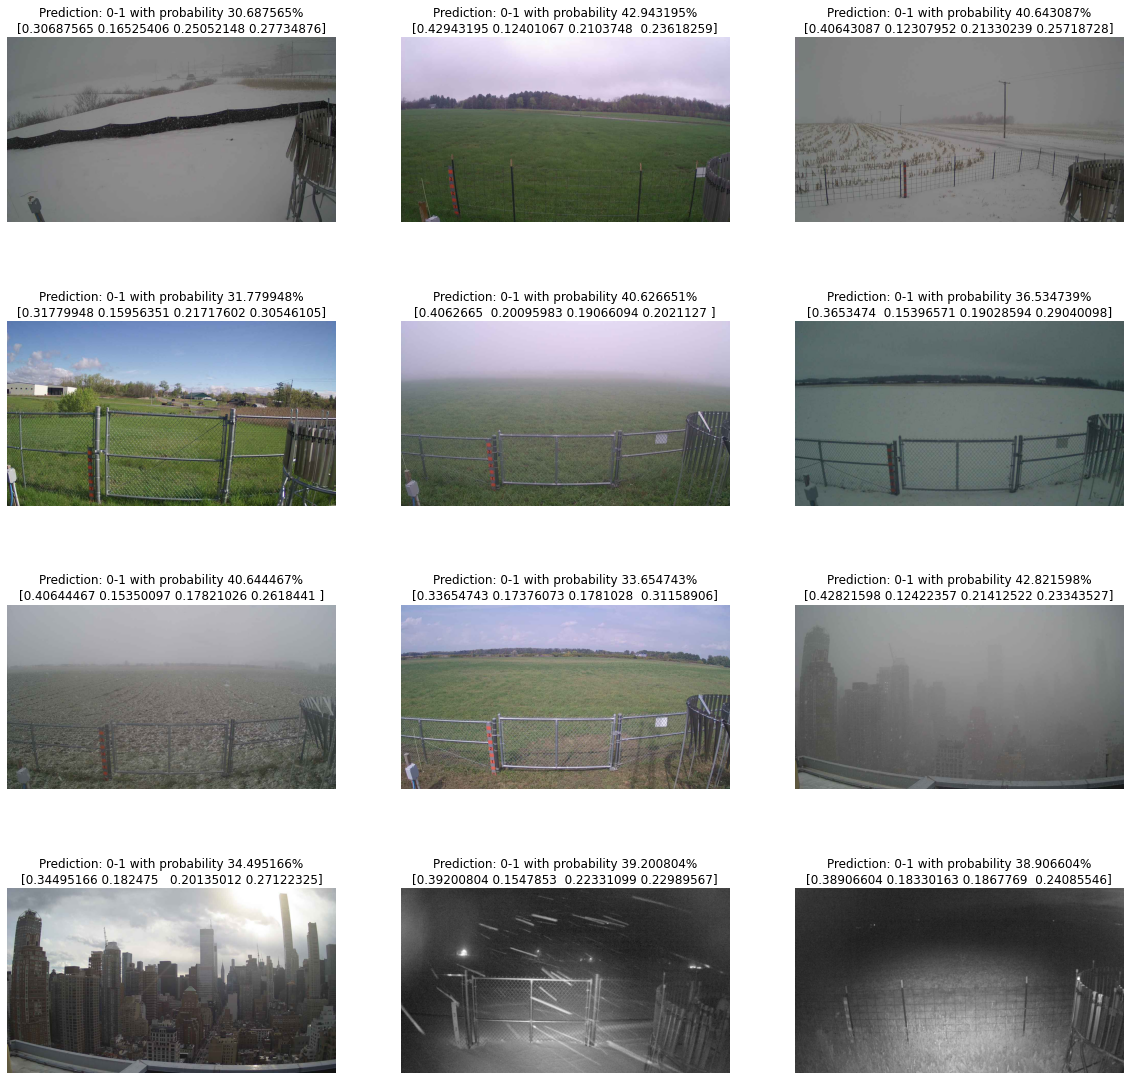

In [44]:
#display predictions for several images
plt.figure(figsize=(20, 20))
for i in range(len(samples)):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(plt.imread(samples[i]))
    plt.axis("off")
    plt.title("Prediction: %s with probability %f%%\n%s" % predict1(model, class_names, path=samples[i]))

# Fine tuning

Lock dense classification layers and unlock convolutional feature extraction layers.

In [ ]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [ ]:
base_learning_rate = 1e-8
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()
len(model.trainable_variables)

In [ ]:
fine_tune_epochs = 5
addl_history = model.fit(train_gen,
                         epochs=fine_tune_epochs,
                         **train_kwargs)
total_epochs += fine_tune_epochs

acc += addl_history.history['accuracy']
val_acc += addl_history.history['val_accuracy']

loss += addl_history.history['loss']
val_loss += addl_history.history['val_loss']

In [ ]:
#uncomment to save augmented model
model.save("/tf/visibility/models/x")

In [ ]:
#load model
# It can be used to reconstruct the model identically and i am going to load this model i ran overnight to save time.
# model = keras.models.load_model("/raid/arnold/clouds_detection/models/custom_cloud_classification_augmented_3_sites")

In [ ]:
tf_model_predictions = model.predict(images)

In [ ]:
print(tf_model_predictions.shape) #“Prediction results shape:”, (219, 7)
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
# predicted_labels = class_names[predicted_ids]
print(predicted_ids)

## Confusion Matrix

In [45]:
## change below path to /tf/username/model_img/ALL
TEST_PATH = '/tf/visibility/model_img/0721_DS2alt/' #GFAL
test_data_dir = pathlib.Path(TEST_PATH)
#resize image 
# sz=224
# List containing the entries in the directory given by PATH
os.listdir(PATH)
image_count = len(list(test_data_dir.glob('*/*.jpg')))

#total image count
print(image_count)

21486


In [46]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_data_dir,
  validation_split=.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  class_names = {'0-1': 0, '2': 1, '3': 2, '4': 3}) #{'poor': 0, 'reduced': 1, 'fair': 2, 'excellent': 3})

y_true = np.concatenate([y for x, y in test_ds], axis=0)

Found 21486 files belonging to 4 classes.
Using 2148 files for validation.


In [47]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
norm_test_ds = test_ds.map(lambda x, y: (rescale(x), y))

In [48]:
%%time
test_preds = model.predict(norm_test_ds)

CPU times: user 35.8 s, sys: 13.6 s, total: 49.4 s
Wall time: 48.9 s


In [49]:
y_pred = [np.argmax(out) for out in test_preds]
test_diffs = [y_pred[i] - y_true[i] for i in range(len(y_true))]
print('Test accuracy: %f%%' % (100 * sum([0 if diff else 1 for diff in test_diffs]) / len(test_diffs)))

Test accuracy: 4.702048%


In [50]:
from sklearn.metrics import confusion_matrix as conf_mat

cmat = conf_mat(y_true, y_pred)
cmat_pro = conf_mat(y_true, y_pred, normalize = 'true') #confusion matrix of proportions

[[  57    0    0    0]
 [  54    0    0    3]
 [  52    0    0    3]
 [1935    0    0   44]]
[[1.         0.         0.         0.        ]
 [0.94736842 0.         0.         0.05263158]
 [0.94545455 0.         0.         0.05454545]
 [0.97776655 0.         0.         0.02223345]]


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


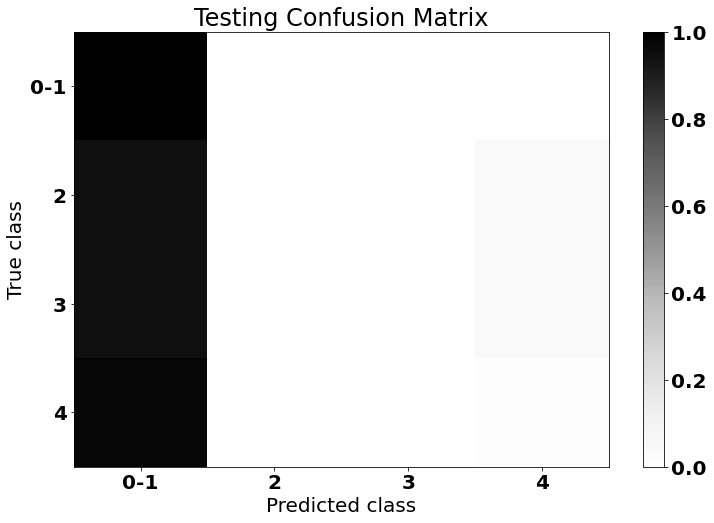

In [51]:
print(cmat)
print(cmat_pro)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
plt.rc('font', **font)

plt.rcParams['figure.figsize'] = [12, 8]
plt.pcolormesh(cmat_pro, cmap = 'Greys')
plt.gca().invert_yaxis()
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('Testing Confusion Matrix')

tick_args = (np.arange(0.5, len(class_names) + 0.5, 1), [name for name in class_names]) #np.arange(0, len(class_names), 1))
plt.xticks(*tick_args)
plt.yticks(*tick_args)
plt.colorbar()

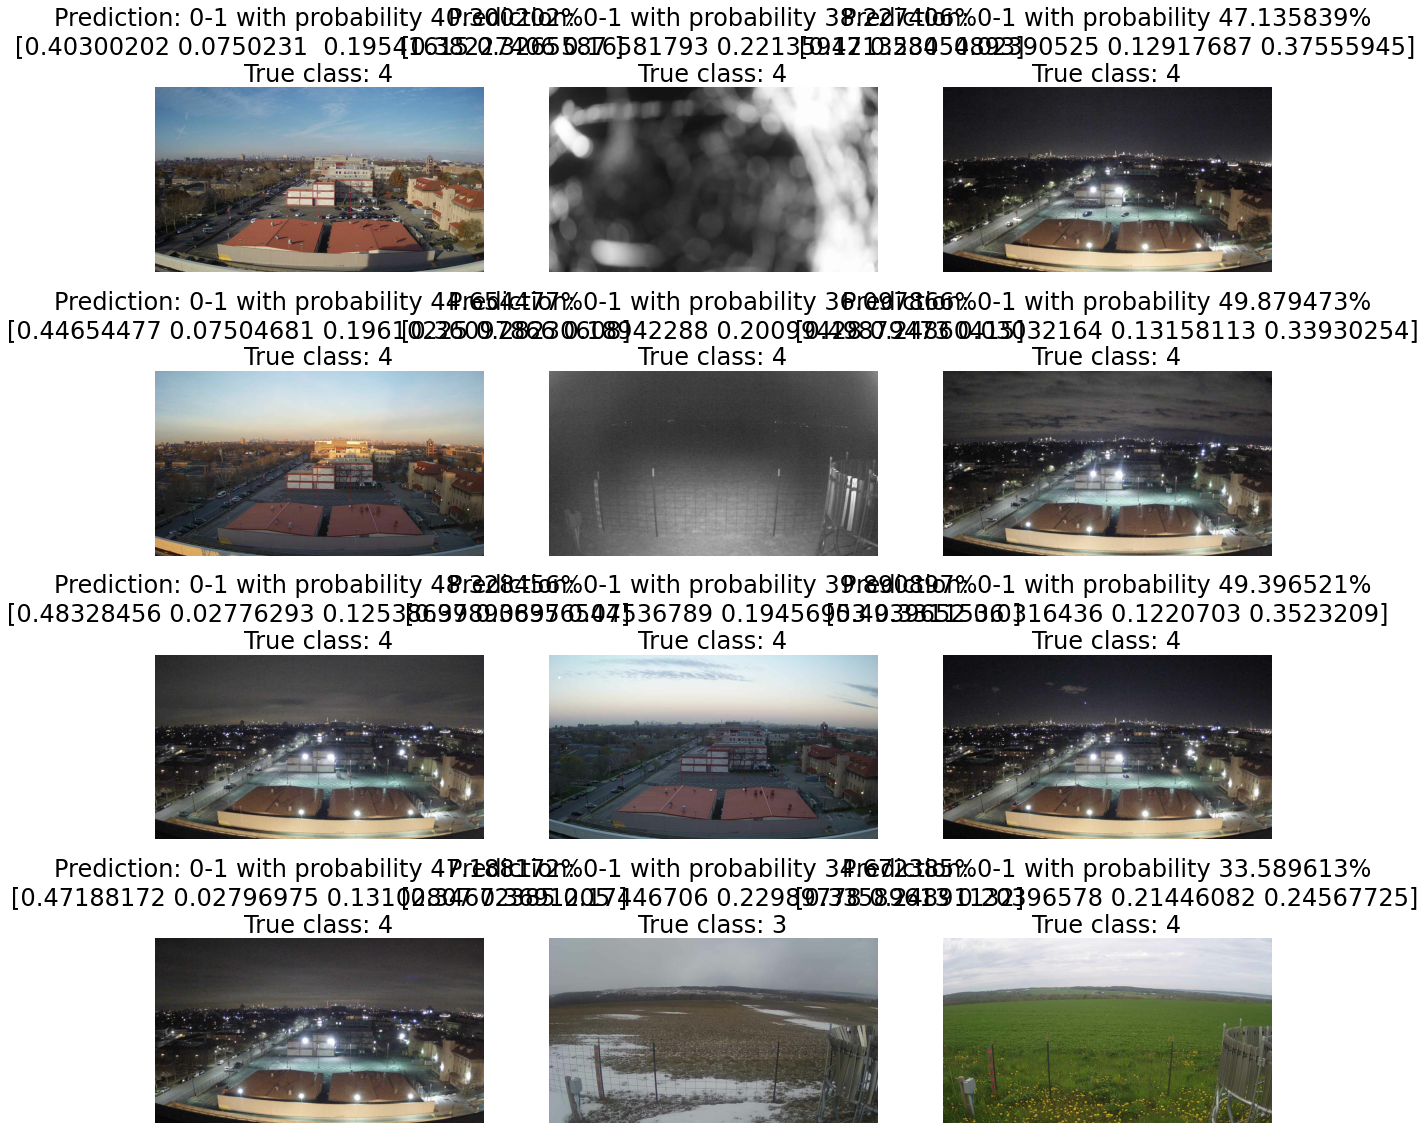

In [52]:
#display predictions for several images
plt.figure(figsize=(20, 20))
for images, labels in norm_test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow((images[i] + 1) / 2)
        plt.axis("off")
        plt.title("Prediction: %s with probability %f%%\n%s\nTrue class: %s" %
                  (*predict1(model, class_names, norm_img=images[i]), class_names[labels[i].numpy()]))